# Imports

In [ ]:
import cProfile, pstats, sys, socket, time, numba
import numpy as np
import matplotlib.pyplot as plt
import cupy as cp
from cupyx.profiler import benchmark
from numba import cuda
# !pip install mpi4py
from mpi4py import MPI


# The Poisson Problem

## Parameters

## Initialising the problem

In [ ]:
PRECISION = np.float64

def init_problem(np, ni, nj, nk):
    global x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d

    # Non-uniform grid
    x = (np.linspace(0, 1, ni)**1.2).astype(PRECISION)
    y = (np.linspace(0, 1, nj)**1.5).astype(PRECISION)
    z = (np.linspace(0, 1, nk)**1.1).astype(PRECISION)

    dx = np.gradient(x).astype(PRECISION)
    dy = np.gradient(y).astype(PRECISION)
    dz = np.gradient(z).astype(PRECISION)

    # Initialize coefficients
    aw3d = np.zeros((ni, nj, nk), dtype=PRECISION)
    ae3d = np.zeros((ni, nj, nk), dtype=PRECISION)
    as3d = np.zeros((ni, nj, nk), dtype=PRECISION)
    an3d = np.zeros((ni, nj, nk), dtype=PRECISION)
    al3d = np.zeros((ni, nj, nk), dtype=PRECISION)
    ah3d = np.zeros((ni, nj, nk), dtype=PRECISION)

    aw3d = (dy[:, None, None] * dz[None, None, :]) / dx[None, :, None]
    ae3d = aw3d.copy()
    as3d = (dx[:, None, None] * dz[None, None, :]) / dy[None, :, None]
    an3d = as3d.copy()
    al3d = (dx[:, None, None] * dy[None, :, None]) / dz[None, None, :]
    ah3d = al3d.copy()

    # Calculate the total coefficient matrix
    ap3d = (aw3d + ae3d + as3d + an3d + al3d + ah3d).astype(PRECISION)

    # Set multiple sources
    su3d = np.ones((ni, nj, nk), dtype=PRECISION) * 1e-20
    su3d[ni // 4, nj // 4, nk // 4] = 50
    su3d[3 * ni // 4, 3 * nj // 4, 3 * nk // 4] = -50

    # Initialize solution array
    p3d = np.ones((ni, nj, nk), dtype=PRECISION) * 1e-20

def visualize_solution(p):
    ni, nj, nk = p.shape
    slice_idx = nk // 2

    data = p[:, :, slice_idx]
    norm_data = (data - np.min(data)) / (np.max(data) - np.min(data) + 1e-12)

    plt.figure(figsize=(8, 6))
    plt.imshow(norm_data.T, origin='lower', aspect='equal', cmap='viridis')
    plt.colorbar(label='Normalized Potential')
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.title(f"Solution Slice: xy Plane (Index {slice_idx})")
    plt.show()

## Iterative Solvers

### CPU Solver

In [ ]:
def solve_it_cpu(phi3d, aw3d, ae3d, as3d, an3d, al3d, ah3d, su3d, ap3d, convergence_limit, niter):
    for n in range(niter):
        phi3d = ((ae3d * np.roll(phi3d, -1, axis=0) + aw3d * np.roll(phi3d, 1, axis=0) +
                  an3d * np.roll(phi3d, -1, axis=1) + as3d * np.roll(phi3d, 1, axis=1) +
                  ah3d * np.roll(phi3d, -1, axis=2) + al3d * np.roll(phi3d, 1, axis=2)) + su3d) / ap3d

        residual = np.zeros_like(phi3d, dtype=phi3d.dtype)

        residual[1:-1, 1:-1, 1:-1] = (
            su3d[1:-1, 1:-1, 1:-1]
            - ap3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, 1:-1]
            + aw3d[1:-1, 1:-1, 1:-1] * phi3d[:-2, 1:-1, 1:-1]  # West
            + ae3d[1:-1, 1:-1, 1:-1] * phi3d[2:, 1:-1, 1:-1]   # East
            + as3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, :-2, 1:-1]  # South
            + an3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 2:, 1:-1]   # North
            + al3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, :-2]  # Lower
            + ah3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, 2:]   # Higher
        )

        residual_norm = np.linalg.norm(residual)
        if residual_norm < convergence_limit:
            break

    return phi3d, residual_norm

def solve_cpu():
    return solve_it_cpu(p3d,aw3d,ae3d,as3d,an3d,al3d,ah3d,su3d,ap3d,convergence_limit,niter)

### Cupy solver

In [ ]:
def solve_it_cupy(phi3d,aw3d,ae3d,as3d,an3d,al3d,ah3d,su3d,ap3d,tol_conv,nmax, log = False):
  for n in range(0,nmax):
    phi3d = ((ae3d * cp.roll(phi3d, -1, axis=0) + aw3d * cp.roll(phi3d, 1, axis=0) +
              an3d * cp.roll(phi3d, -1, axis=1) + as3d * cp.roll(phi3d, 1, axis=1) +
              ah3d * cp.roll(phi3d, -1, axis=2) + al3d * cp.roll(phi3d, 1, axis=2)) + su3d) / ap3d

    residual = np.zeros_like(phi3d, dtype=phi3d.dtype)

    residual[1:-1, 1:-1, 1:-1] = (
        su3d[1:-1, 1:-1, 1:-1]
        - ap3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, 1:-1]
        + aw3d[1:-1, 1:-1, 1:-1] * phi3d[:-2, 1:-1, 1:-1]  # West
        + ae3d[1:-1, 1:-1, 1:-1] * phi3d[2:, 1:-1, 1:-1]   # East
        + as3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, :-2, 1:-1]  # South
        + an3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 2:, 1:-1]   # North
        + al3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, :-2]  # Lower
        + ah3d[1:-1, 1:-1, 1:-1] * phi3d[1:-1, 1:-1, 2:]   # Higher
    )

    residual_norm = cp.linalg.norm(residual)
    if residual_norm < tol_conv:
        break

  return phi3d, residual_norm

def solve_cupy():
  return solve_it_cupy(p3d,aw3d,ae3d,as3d,an3d,al3d,ah3d,su3d,ap3d,convergence_limit,niter)

### numba solver

In [ ]:
from numba import njit
from numba import prange

@njit(parallel=True)
def solve_it_numba(phi3d, aw3d, ae3d, as3d, an3d, al3d, ah3d, su3d, ap3d, convergence_limit, niter):
    nx, ny, nz = phi3d.shape
    for n in prange(niter):
        # Create a temporary array for the updated phi3d
        new_phi3d = np.empty_like(phi3d)

        for i in prange(nx):
            for j in prange(ny):
                for k in prange(nz):
                    # Handle periodic or zero-padding boundaries
                    ip = i + 1 if i + 1 < nx else 0
                    im = i - 1 if i - 1 >= 0 else nx - 1
                    jp = j + 1 if j + 1 < ny else 0
                    jm = j - 1 if j - 1 >= 0 else ny - 1
                    kp = k + 1 if k + 1 < nz else 0
                    km = k - 1 if k - 1 >= 0 else nz - 1

                    # Update phi3d based on neighboring values
                    new_phi3d[i, j, k] = (
                        ae3d[i, j, k] * phi3d[ip, j, k] +
                        aw3d[i, j, k] * phi3d[im, j, k] +
                        an3d[i, j, k] * phi3d[i, jp, k] +
                        as3d[i, j, k] * phi3d[i, jm, k] +
                        ah3d[i, j, k] * phi3d[i, j, kp] +
                        al3d[i, j, k] * phi3d[i, j, km] +
                        su3d[i, j, k]
                    ) / ap3d[i, j, k]

        # Swap the arrays for the next iteration
        phi3d[:] = new_phi3d

        # Compute the residual
        residual = np.zeros_like(phi3d)
        for i in prange(1, nx - 1):
            for j in prange(1, ny - 1):
                for k in prange(1, nz - 1):
                    residual[i, j, k] = (
                        su3d[i, j, k]
                        - ap3d[i, j, k] * phi3d[i, j, k]
                        + aw3d[i, j, k] * phi3d[i - 1, j, k]  # West
                        + ae3d[i, j, k] * phi3d[i + 1, j, k]  # East
                        + as3d[i, j, k] * phi3d[i, j - 1, k]  # South
                        + an3d[i, j, k] * phi3d[i, j + 1, k]  # North
                        + al3d[i, j, k] * phi3d[i, j, k - 1]  # Lower
                        + ah3d[i, j, k] * phi3d[i, j, k + 1]  # Higher
                    )

        # Calculate residual norm
        residual_norm = 0.0
        for i in prange(nx):
            for j in prange(ny):
                for k in prange(nz):
                    residual_norm += residual[i, j, k] ** 2
        residual_norm = np.sqrt(residual_norm)

        # Check for convergence
        if residual_norm < convergence_limit:
            break

    return phi3d, residual_norm


def solve_numba_jit():
    return solve_it_numba(p3d,aw3d,ae3d,as3d,an3d,al3d,ah3d,su3d,ap3d,convergence_limit,niter)

### CUDA numba solver

In [1]:
@cuda.jit
def jacobi_iteration(phi, phi_new, residual, north, south, east, west, upper, lower, source, central, iterations):
    i, j, k = cuda.grid(3)
    ni, nj, nk = phi.shape

    for _ in range(iterations):
        if 1 <= i < ni - 1 and 1 <= j < nj - 1 and 1 <= k < nk - 1:
            # Compute the new value of phi at (i, j, k)
            phi_new[i, j, k] = (
                east[i, j, k] * phi[i + 1, j, k] +
                west[i, j, k] * phi[i - 1, j, k] +
                north[i, j, k] * phi[i, j + 1, k] +
                south[i, j, k] * phi[i, j - 1, k] +
                upper[i, j, k] * phi[i, j, k + 1] +
                lower[i, j, k] * phi[i, j, k - 1] +
                source[i, j, k]
            ) / central[i, j, k]

            phi[i, j, k] = phi_new[i, j, k]
            cuda.syncthreads()

            residual[i, j, k] = (
                source[i, j, k]
                - central[i, j, k] * phi[i, j, k]
                + west[i, j, k] * phi[i - 1, j, k]
                + east[i, j, k] * phi[i + 1, j, k]
                + south[i, j, k] * phi[i, j - 1, k]
                + north[i, j, k] * phi[i, j + 1, k]
                + lower[i, j, k] * phi[i, j, k - 1]
                + upper[i, j, k] * phi[i, j, k + 1]
            )

@cuda.jit
def compute_residual(phi, su, residual, west, east, south, north, lower, upper, central):
    i, j, k = cuda.grid(3)
    ni, nj, nk = phi.shape

    if 1 <= i < ni - 1 and 1 <= j < nj - 1 and 1 <= k < nk - 1:
        residual[i, j, k] = (
            su[i, j, k]
            - central[i, j, k] * phi[i, j, k]
            + west[i, j, k] * phi[i - 1, j, k]
            + east[i, j, k] * phi[i + 1, j, k]
            + south[i, j, k] * phi[i, j - 1, k]
            + north[i, j, k] * phi[i, j + 1, k]
            + lower[i, j, k] * phi[i, j, k - 1]
            + upper[i, j, k] * phi[i, j, k + 1]
        )

def solve_numba(batch = 100):
    transfer_cost = 0

    threads_per_block = (8, 8, 8)
    blocks_per_grid = tuple(
        (np.array(p3d.shape) + np.array(threads_per_block) - 1) //
        np.array(threads_per_block)
    )

    elapsed = time.time()
    phi_d = cuda.to_device(p3d)
    phi_new_d = cuda.to_device(p3d)
    north_d = cuda.to_device(an3d)
    south_d = cuda.to_device(as3d)
    east_d = cuda.to_device(ae3d)
    west_d = cuda.to_device(aw3d)
    upper_d = cuda.to_device(ah3d)
    lower_d = cuda.to_device(al3d)
    source_d = cuda.to_device(su3d)
    central_d = cuda.to_device(ap3d)
    residual_d = cuda.device_array_like(p3d)
    transfer_cost += time.time() - elapsed

    iterations = niter // batch if batch < niter else niter
    for i in range(iterations):
        jacobi_iteration[blocks_per_grid, threads_per_block](
            phi_d, phi_new_d, residual_d, north_d, south_d, east_d, west_d, upper_d, lower_d,
            source_d, central_d, batch if batch < niter else 1
        )

        elapsed = time.time()
        residual = residual_d.copy_to_host()
        transfer_cost += time.time() - elapsed
        residual_norm = np.linalg.norm(residual)

        if residual_norm < convergence_limit:
            break

    elapsed = time.time()
    phi = phi_d.copy_to_host()
    transfer_cost += time.time() - elapsed

    return phi, residual_norm, transfer_cost

NameError: name 'cuda' is not defined

### CUDA numba & MPI4py solver

In [ ]:
def solve_numba_mpi4py():
    comm = MPI.COMM_WORLD
    rank = comm.Get_rank()
    size = comm.Get_size()

    # Domain decomposition
    local_nx = ni // size + (1 if rank < ni % size else 0)
    start = rank * (ni // size) + min(rank, ni % size)
    end = start + local_nx

    if local_nx <= 0:
        return None

    # Local grid with ghost layers
    local_p = np.zeros((local_nx + 2, nj, nk))  # Includes ghost layers
    local_su = su3d[start:end, :, :]
    local_aw = aw3d[start:end, :, :]
    local_ae = ae3d[start:end, :, :]
    local_as = as3d[start:end, :, :]
    local_an = an3d[start:end, :, :]
    local_al = al3d[start:end, :, :]
    local_ah = ah3d[start:end, :, :]
    local_ap = ap3d[start:end, :, :]

    # CUDA setup
    threads_per_block = (8, 8, 8)
    blocks_per_grid = tuple(
        (np.array(local_p.shape) + np.array(threads_per_block) - 1) //
        np.array(threads_per_block)
    )

    # Transfer to GPU
    p_d = cuda.to_device(local_p)
    p_new_d = cuda.to_device(local_p)
    aw_d = cuda.to_device(local_aw)
    ae_d = cuda.to_device(local_ae)
    as_d = cuda.to_device(local_as)
    an_d = cuda.to_device(local_an)
    al_d = cuda.to_device(local_al)
    ah_d = cuda.to_device(local_ah)
    su_d = cuda.to_device(local_su)
    ap_d = cuda.to_device(local_ap)

    # CUDA setup full
    threads_per_block_full = (8, 8, 8)
    blocks_per_grid_full = tuple(
      (np.array(p3d.shape) + np.array(threads_per_block) - 1) //
      np.array(threads_per_block)
    )

    # Complete weights for residual
    residual_d = cuda.to_device(np.zeros_like(su3d))
    aw3d_d_full = cuda.to_device(aw3d)
    ae3d_d_full = cuda.to_device(ae3d)
    as3d_d_full = cuda.to_device(as3d)
    an3d_d_full = cuda.to_device(an3d)
    al3d_d_full = cuda.to_device(al3d)
    ah3d_d_full = cuda.to_device(ah3d)
    su3d_d_full = cuda.to_device(su3d)
    ap3d_d_full = cuda.to_device(ap3d)

    # Iterative solver
    batch = 1000
    for n in range(niter // batch + 1):
        # Boundary exchange
        if rank > 0:
            sendbuf = p_d[1, :, :].copy_to_host()
            recvbuf = np.empty_like(sendbuf)
            comm.Sendrecv(sendbuf=sendbuf, dest=rank - 1, recvbuf=recvbuf, source=rank - 1)
            p_d[0, :, :] = cuda.to_device(recvbuf)

        if rank < size - 1:
            sendbuf = p_d[-2, :, :].copy_to_host()
            recvbuf = np.empty_like(sendbuf)
            comm.Sendrecv(sendbuf=sendbuf, dest=rank + 1, recvbuf=recvbuf, source=rank + 1)
            p_d[-1, :, :] = cuda.to_device(recvbuf)

        # Solve with Jacobi on GPU
        jacobi_iteration[blocks_per_grid, threads_per_block](
            p_d, p_new_d, an_d, as_d, ae_d, aw_d, ah_d, al_d,
            su_d, ap_d, batch
        )
        p_d, p_new_d = p_new_d, p_d

    # Gather solution on root
    local_result = p_d.copy_to_host()
    recv_counts = comm.gather(local_result.size, root=0)

    if rank == 0:
        displacements = [0] + np.cumsum(recv_counts[:-1]).tolist()
        global_shape = (ni, nj, nk)
        gathered_p = np.zeros(global_shape, dtype=np.float64)
    else:
        gathered_p = None

    comm.Gatherv(sendbuf=local_result.ravel(),
                 recvbuf=(gathered_p.ravel(), recv_counts, displacements, MPI.DOUBLE),
                 root=0)

    # Compute residual on root
    if rank == 0:
        # Allocate GPU memory for full-domain residual computation
        global_p_d = cuda.to_device(gathered_p)
        residual_d = cuda.device_array_like(gathered_p)
        compute_residual[blocks_per_grid_full, threads_per_block_full](
            global_p_d, su3d_d_full, residual_d, aw3d_d_full, ae3d_d_full, as3d_d_full, an3d_d_full,
            al3d_d_full, ah3d_d_full, ap3d_d_full
        )
        residual = residual_d.copy_to_host()
        residual_norm = np.linalg.norm(residual)
    else:
        residual_norm = None

    # Broadcast residual norm to all ranks
    residual_norm = comm.bcast(residual_norm, root=0)

    if rank == 0:
        return gathered_p, residual_norm
    return None

# Tests

### CPU

Time: 9.761366128921509s    Residual: 6.050197382963491


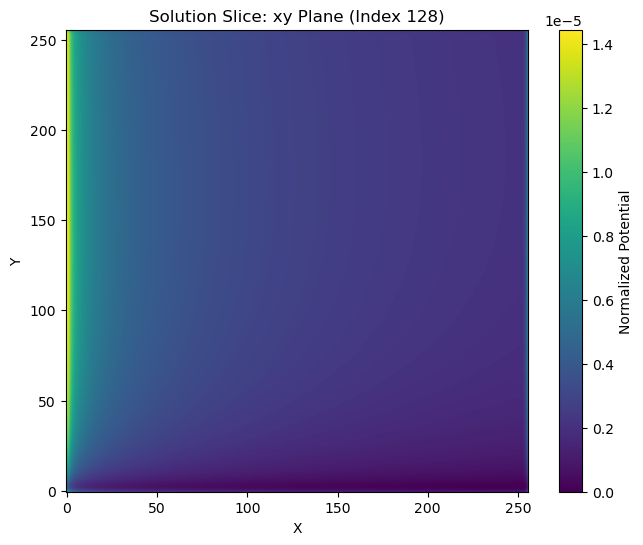

In [ ]:
%matplotlib inline

convergence_limit = 1e-5
niter=10
ni = nj = nk = 256

init_problem(np, ni, nj, nk)
start = time.time()
p3d, resid = solve_cpu()
end = time.time()
print(f'Time: {end - start}s    Residual: {resid}')
visualize_solution(p3d)

### CuPy

Time: 1.0731306076049805s    Residual: 0.32002311553266527


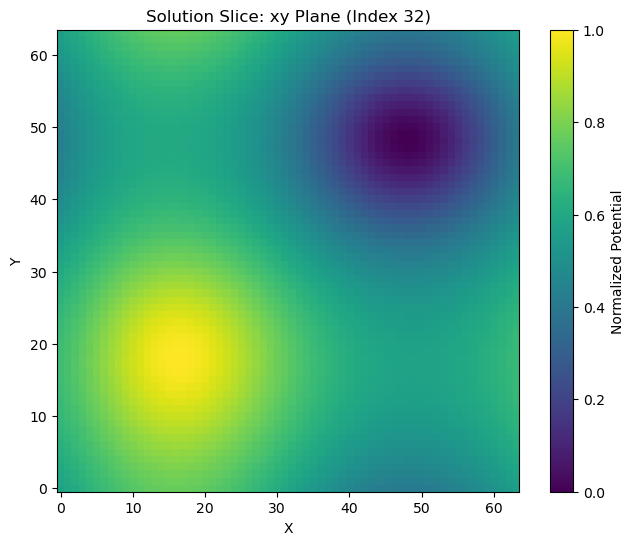

In [ ]:
%matplotlib inline

convergence_limit = 1e-5
niter=1000
ni = nj = nk = 64

init_problem(cp, ni, nj, nk)
start = time.time()
p3d, resid = solve_cupy()
end = time.time()
print(f'Time: {end - start}s    Residual: {resid}')
visualize_solution(p3d.get())

### numba njit

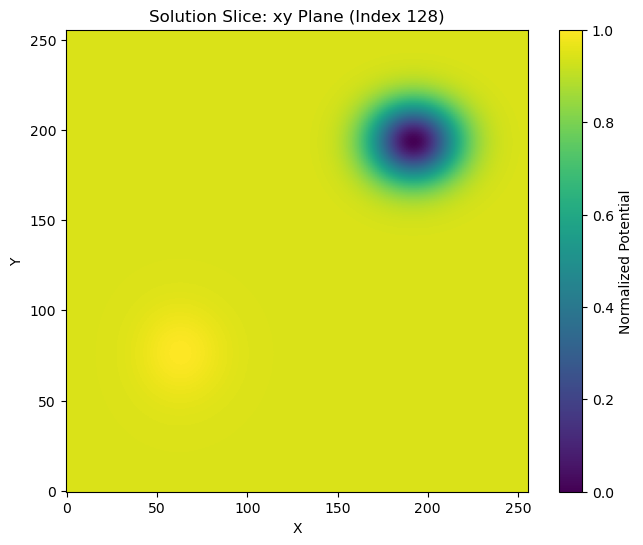

In [ ]:
%matplotlib inline
import pandas as pd

# Number of iterations in GS solver
niter = 1000
ni = nj = nk = 256
convergence_limit = 1e-5

init_problem(np, ni, nj, nk)
start = get_curr_date()
p3d, resid = solve_numba_jit()
end = get_curr_date()

# print(f'Time: {end - start}s    Residual: {resid}')
visualize_solution(p3d)

df = pd.DataFrame([], columns=['Solver Name', 'Grid Size', 'Start Date', 'End Date'])
df.loc[len(df)] = ['CPU w/ numba', ni, start, end]
df.to_csv(f'data-cpu-numba-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

## numba CUDA

Time: 0.4817171096801758s    Residual: 0.04634418475901351
Transfer cost: 0.12102603912353516s


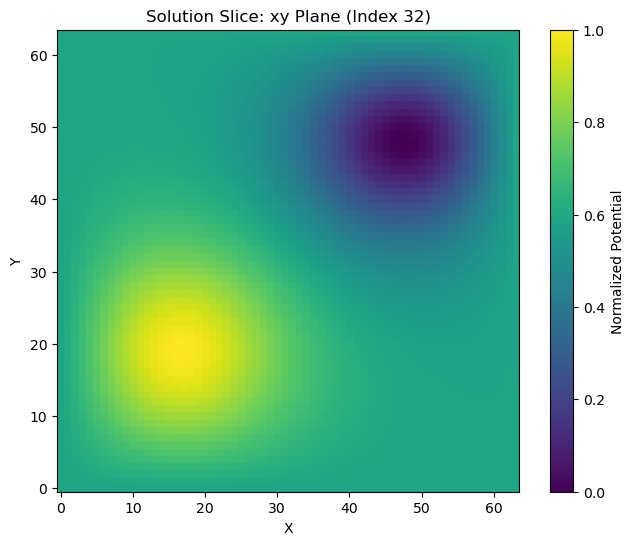

In [ ]:
%matplotlib inline

# Number of iterations in GS solver
niter = 1000
ni = nj = nk = 64
convergence_limit = 1e-5

init_problem(np, ni, nj, nk)
start = time.time()
p3d, resid, transfer_cost = solve_numba(10)
end = time.time()

print(f'Time: {end - start}s    Residual: {resid}')
print(f'Transfer cost: {transfer_cost}s')
visualize_solution(p3d)

### numba & mpi4py

In [ ]:
%matplotlib inline

# Number of iterations in GS solver
niter = 1000
ni = nj = nk = 32

init_problem(np, ni, nj, nk)
start = time.time()
p3d, resid = solve_numba_mpi4py()
end = time.time()

print(resid)
print(f'{end - start}s')
visualize_solution(p3d)

# Benchmarking

## Computation

In [ ]:
def measure_time(f):
  start = time.time()
  result = f()
  return time.time() - start, result

sizes = [8, 16, 32, 64, 128, 256]

times_cpu = []
residuals_cpu = []
times_cupy = []
residuals_cupy = []
times_numba_njit = []
residuals_numba_njit = []
times_numba = []
residuals_numba = []

niter=1000
convergence_limit=1e-5

for s in sizes:
  print(f'Computing grid sizes {s}...')
  ni = nj = nk = s
  init_problem(np, ni, nj, nk)

  elapsed, result = measure_time(solve_cpu)
  times_cpu.append(elapsed)
  residuals_cpu.append(result[1])

  elapsed, result = measure_time(solve_numba_jit)
  times_numba_njit.append(elapsed)
  residuals_numba_njit.append(result[1])

  elapsed, result = measure_time(solve_numba)
  times_numba.append(elapsed)
  residuals_numba.append(result[1])

  del x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d
  init_problem(cp, ni, nj, nk)

  elapsed, result = measure_time(solve_cupy)
  times_cupy.append(elapsed)
  residuals_cupy.append(result[1])
  del x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d

Computing grid sizes 8...
Computing grid sizes 16...
Computing grid sizes 32...
Computing grid sizes 64...
Computing grid sizes 128...
Computing grid sizes 256...


### Redo 1

In [ ]:
def measure_time(f):
  start = time.time()
  result = f()
  return time.time() - start, result

sizes = [8, 16, 32, 64, 128, 256]

times_numba = []
residuals_numba = []

niter=1000
convergence_limit=1e-5

for s in sizes:
  print(f'Computing grid sizes {s}...')
  ni = nj = nk = s
  init_problem(np, ni, nj, nk)

  elapsed, result = measure_time(solve_numba)
  times_numba.append(elapsed)
  residuals_numba.append(result[1])

  del x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d

Computing grid sizes 8...
Computing grid sizes 16...
Computing grid sizes 32...
Computing grid sizes 64...
Computing grid sizes 128...


/apps/Arch/software/numba/0.58.1-foss-2023a/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 1 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/apps/Arch/software/numba/0.58.1-foss-2023a/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 8 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))
/apps/Arch/software/numba/0.58.1-foss-2023a/lib/python3.11/site-packages/numba/cuda/dispatcher.py:536: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Computing grid sizes 256...


## Plotting

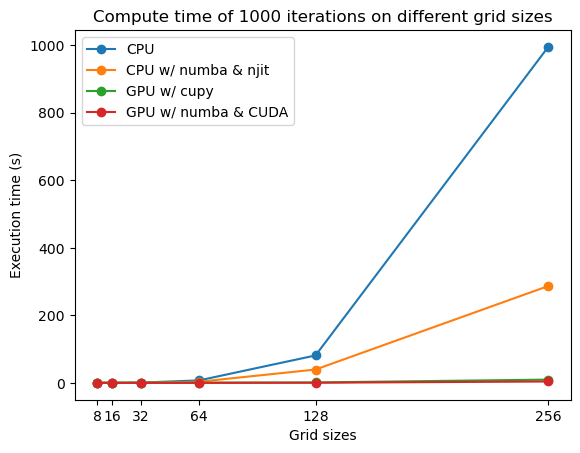

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline
plt.plot(sizes[:len(times_cpu)], times_cpu, label='CPU', marker='o')
plt.plot(sizes[:len(times_numba_njit)], times_numba_njit, label='CPU w/ numba & njit', marker='o')
plt.plot(sizes[:len(times_cupy)], times_cupy, label='GPU w/ cupy', marker='o')
plt.plot(sizes[:len(times_numba)], times_numba, label='GPU w/ numba & CUDA', marker='o')
plt.title('Compute time of 1000 iterations on different grid sizes')
plt.xlabel('Grid sizes')
plt.ylabel('Execution time (s)')
plt.xticks(sizes)
plt.legend()
plt.show()
plt.savefig('compute_time.svg', format='svg')

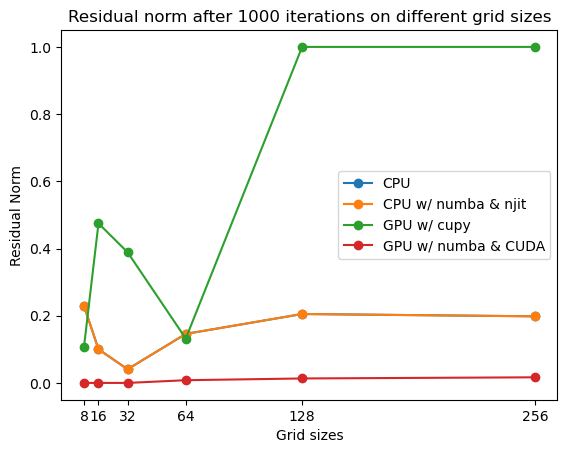

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline

tmp = []

for i in range(len(sizes)):
    tmp.append(residuals_cupy[i].get())

plt.plot(sizes[:len(residuals_cpu)], residuals_cpu, label='CPU', marker='o')
plt.plot(sizes[:len(residuals_numba_njit)], residuals_numba_njit, label='CPU w/ numba & njit', marker='o')
plt.plot(sizes[:len(tmp)], tmp, label='GPU w/ cupy', marker='o')
plt.plot(sizes[:len(residuals_numba)], residuals_numba, label='GPU w/ numba & CUDA', marker='o')
plt.title('Residual norm after 1000 iterations on different grid sizes')
plt.xlabel('Grid sizes')
plt.ylabel('Residual Norm')
plt.xticks(sizes)
plt.legend()
plt.show()
plt.savefig('residuals.svg', format='svg')

In [ ]:
import pandas as pd

df = pd.DataFrame([], columns=['Grid Size', 'CPU', 'numba & njit', 'CuPy', 'numba & CUDA'])
df2 = pd.DataFrame([], columns=['Grid Size', 'CPU', 'numba & njit', 'CuPy', 'numba & CUDA'])

for i in range(len(sizes)):
    df.loc[len(df)] = [sizes[i], times_cpu[i], times_numba_njit[i], times_cupy[i], times_numba[i]]
    df2.loc[len(df2)] = [sizes[i], residuals_cpu[i], residuals_numba_njit[i], tmp[i], residuals_numba[i]]

df.to_csv(f'compute_times.csv', sep='\t', encoding='utf-8', header=True)
df2.to_csv(f'residuals.csv', sep='\t', encoding='utf-8', header=True)

In [ ]:
def measure_time(f):
  start = time.time()
  result = f()
  return time.time() - start, result

times_cupy = []
residuals_cupy = []
times_numba = []
residuals_numba = []

iterations_nb = []
niter=10
convergence_limit=1e-5
ni = nj = nk = 256

while niter <= 10000:
  iterations_nb.append(niter)
  print(f'Computing {niter} iterations...')
  init_problem(np, ni, nj, nk)

  elapsed, result = measure_time(solve_numba)
  times_numba.append(elapsed)
  residuals_numba.append(result[1])

  del x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d
  init_problem(cp, ni, nj, nk)

  elapsed, result = measure_time(solve_cupy)
  times_cupy.append(elapsed)
  residuals_cupy.append(result[1])
  del x, y, z, dx, dy, dz, aw3d, ae3d, as3d, an3d, al3d, ah3d, ap3d, su3d, p3d

  niter = niter * 10

Computing 1000 iterations...


KeyboardInterrupt: 

In [ ]:
%matplotlib inline
plt.plot(iterations_nb[:len(times_cupy)], times_cupy, label='GPU w/ cupy', marker='o')
plt.plot(iterations_nb[:len(times_numba)], times_numba, label='GPU w/ numba & CUDA', marker='o')
plt.title('Compute time of increasing number of iterations on CuPy & numba w/ CUDA')
plt.xlabel('Number of iterations')
plt.ylabel('Execution time (s)')
plt.xticks(iterations_nb)
plt.legend()
plt.show()
plt.savefig('compute_time.svg', format='svg')

In [ ]:
%matplotlib inline

# Number of iterations in GS solver
niter = 1000
convergence_limit = 1e-5
total_times = []
transfers = []
sizes = [8, 16, 32, 64, 128, 256]
batch_size = 1
i = 0

while batch_size <= niter:
    print(f'batch_size {batch_size}')
    total_times.append([])
    transfers.append([])

    for s in sizes:
        print(f'    grid_size {s}')
        ni = nj = nk = s
        init_problem(np, ni, nj, nk)
        start = time.time()
        p3d, resid, transfer_cost = solve_numba(1)
        end = time.time()

        total_times[i].append(end - start)
        transfers[i].append(transfer_cost)

    batch_size = batch_size * 10
    i += 1

batch_size 1
    grid_size 8
    grid_size 16
    grid_size 32
    grid_size 64
    grid_size 128
    grid_size 256
batch_size 10
    grid_size 8
    grid_size 16
    grid_size 32
    grid_size 64
    grid_size 128
    grid_size 256
batch_size 100
    grid_size 8
    grid_size 16
    grid_size 32
    grid_size 64
    grid_size 128
    grid_size 256
batch_size 1000
    grid_size 8
    grid_size 16
    grid_size 32
    grid_size 64
    grid_size 128
    grid_size 256


In [ ]:
import pandas as pd

df = pd.DataFrame([], columns=['Grid Size', 'Batch Size', 'Compute Time', 'Transfer Time'])

batch = 1
for i in range(len(total_times)):
    for j in range(len(total_times[i])):
        df.loc[len(df)] = [sizes[j], batch, total_times[i][j], transfers[i][j]]

    batch = batch*10

df.to_csv(f'transfers.csv', sep='\t', encoding='utf-8', header=True)

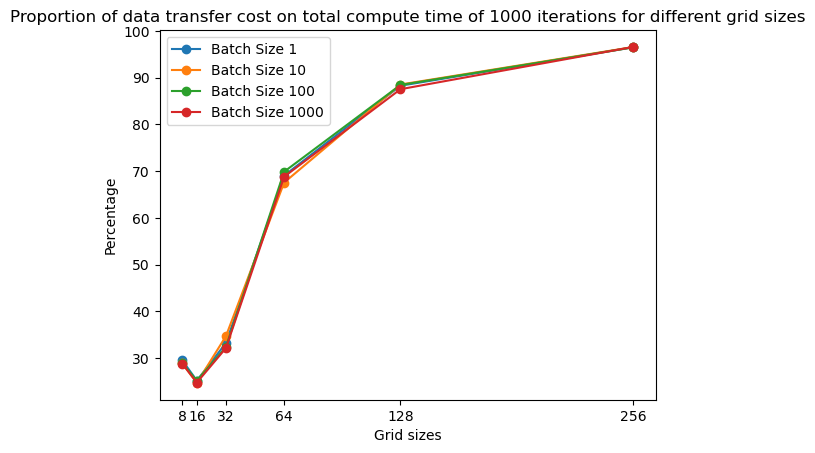

<Figure size 640x480 with 0 Axes>

In [ ]:
%matplotlib inline

relation = []
batch = 1
for i in range(len(total_times)):
    for j in range(len(total_times[i])):
        relation.append([])
        relation[i].append((transfers[i][j]/total_times[i][j])*100)

    plt.plot(sizes[:len(relation[i])], relation[i], label=f'Batch Size {batch}', marker='o')
    batch = batch*10

plt.title('Proportion of data transfer cost on total compute time of 1000 iterations for different grid sizes')
plt.xlabel('Grid sizes')
plt.ylabel('Percentage')
plt.xticks(sizes)
plt.legend()
plt.show()
plt.savefig('compute_time.svg', format='svg')

# Comparisons

In [ ]:
import pandas as pd
from datetime import datetime

def get_curr_date():
    now = datetime.now()
    return now.strftime('%Y-%m-%d-%H-%M-%S') + f'-{now.microsecond // 1000:03d}'


def register_data(np, solver, name):
    init_problem(np, ni, nj, nk)
    start = get_curr_date()
    res, residual = solver()
    if isinstance(res, cp.ndarray):
      res = res.get()
    end = get_curr_date()
    df.loc[len(df)] = [name, ni, start, end]


df = pd.DataFrame([], columns=['Solver Name', 'Grid Size', 'Start Date', 'End Date'])

niter=100000
convergence_limit=1e-5
ni = nj = nk = 256

In [ ]:
register_data(np, solve_cpu, 'CPU Solver')
df.to_csv(f'data-cpu-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

In [ ]:
register_data(cp, solve_cupy, 'CuPy Solver')
df.to_csv(f'data-cupy-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

In [ ]:
register_data(np, solve_numba, 'numba Solver')
df.to_csv(f'data-numba-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

In [ ]:
register_data(np, solve_cuda_mpi4py, 'numba & mpi4py Solver')
df.to_csv(f'data-numba-mpi4py-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

## Data

In [ ]:
import pandas as pd
from datetime import datetime

df = pd.read_csv('GPU Power Usage-data-2024-12-18 00_57_24.csv', sep=',', encoding='utf-8')
df['Time'] = pd.to_datetime(df['Time'], format='%Y-%m-%d %H:%M:%S')

df2 = pd.read_csv('data-cupy-2024-12-18-00-39-07-444.csv', sep='\t', encoding='utf-8')

start_numba = datetime.strptime(df2.loc[df2['Solver Name'] == 'numba Solver', 'Start Date'][0], '%Y-%m-%d-%H-%M-%S-%f')
end_numba = datetime.strptime(df2.loc[df2['Solver Name'] == 'numba Solver', 'End Date'][0], '%Y-%m-%d-%H-%M-%S-%f')

start_cupy = datetime.strptime(df2.loc[df2['Solver Name'] == 'CuPy Solver', 'Start Date'][1], '%Y-%m-%d-%H-%M-%S-%f')
end_cupy = datetime.strptime(df2.loc[df2['Solver Name'] == 'CuPy Solver', 'End Date'][1], '%Y-%m-%d-%H-%M-%S-%f')

total_power_numba = df[(df['Time'] >= start_numba) & (df['Time'] <= end_numba)]['GPU0_usage'].apply(lambda x: float(x.replace('W', ''))).sum()
avg_power_numba = df[(df['Time'] >= start_numba) & (df['Time'] <= end_numba)]['GPU0_usage'].apply(lambda x: float(x.replace('W', ''))).mean()
print(f'numba Solver:')
print(f'{"{:.2f}".format(total_power_numba)} W over {end_numba - start_numba}')
print(f'{"{:.2f}".format(avg_power_numba)} W every 15s')

total_power_cupy = df[(df['Time'] >= start_cupy) & (df['Time'] <= end_cupy)]['GPU0_usage'].apply(lambda x: float(x.replace('W', ''))).sum()
avg_power_cupy = df[(df['Time'] >= start_cupy) & (df['Time'] <= end_cupy)]['GPU0_usage'].apply(lambda x: float(x.replace('W', ''))).mean()
print(f'\nCuPy solver:')
print(f'{"{:.2f}".format(total_power_cupy)} W over {end_cupy - start_cupy}')
print(f'{"{:.2f}".format(avg_power_cupy)} W every 15s')

print(f'\nDifferential total: {"{:.2f}".format((total_power_cupy*100)/total_power_numba)}%')
print(f'Differential average: {"{:.2f}".format((avg_power_cupy*100)/avg_power_numba)}%')

numba Solver:
2294.00 W over 0:04:32.524000
127.44 W every 15s

CuPy solver:
18848.00 W over 0:18:21.224000
258.19 W every 15s

Differential total: 821.62%
Differential average: 202.59%


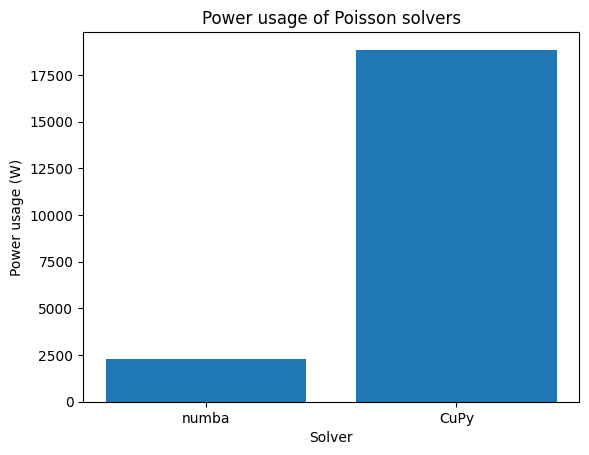

In [ ]:
import matplotlib.pyplot as plt

plt.bar(['numba', 'CuPy'], height=[total_power_numba, total_power_cupy])
plt.title('Power usage of Poisson solvers')
plt.xlabel('Solver')
plt.ylabel('Power usage (W)')
plt.show()

# pyAMG

In [ ]:
import pyamg
from scipy import sparse

def solve_pyamg_vcycle():
    global p3d

    # Solve the system
    start = get_curr_date()
    start_time = time.perf_counter()

    aw = np.matrix.flatten(aw3d)
    ae = np.matrix.flatten(ae3d)
    as1 = np.matrix.flatten(as3d)
    an = np.matrix.flatten(an3d)
    al = np.matrix.flatten(al3d)
    ah = np.matrix.flatten(ah3d)
    ap = np.matrix.flatten(ap3d)

    m = ni * nj * nk

    A = sparse.diags(
        [ap, -ah[:-1], -al[1:], -an[0:-nk], -as1[nk:], -ae, -aw[nj * nk:]],
        [0, 1, -1, nk, -nk, nk * nj, -nk * nj],
        format='csr'
    )

    # Construct the multigrid hierarchy with custom smoothers
    App = pyamg.ruge_stuben_solver(
        A,
        presmoother=('block_jacobi', {'iterations': 2}),  # Block Jacobi pre-smoother
        postsmoother=('block_jacobi', {'iterations': 2})  # Block Jacobi post-smoother
    )

    phi = np.matrix.flatten(p3d)
    su = np.matrix.flatten(su3d)
    phi_org = phi
    res_amg = []

    # Solve using a V-cycle with specified tolerances and iterations
    phi = App.solve(
        su,
        tol=convergence_limit,
        x0=phi,
        residuals=res_amg,
        maxiter=niter,
        cycle='V'
    )
    delta_phi = np.max(np.abs(phi - phi_org))
    resid = np.linalg.norm(A * phi - su)
    p3d = np.reshape(phi, (ni, nj, nk))

    end = get_curr_date()
    end_time = time.perf_counter()
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.4f} seconds")

    return p3d, resid, start, end

In [ ]:
niter=1000000
convergence_limit=1e-10
ni = nj = nk = 256
init_problem(np, ni, nj, nk)

phi3d, resid, start, end = solve_pyamg_vcycle()
visualize_solution(phi3d)
print(f'Residual norm: {resid}')

df = pd.DataFrame([], columns=['Solver Name', 'Grid Size', 'Start Date', 'End Date', 'Result', 'Residual'])
df.loc[len(df)] = ['pyAMG solver', ni, start, end, phi3d, resid]

df.to_csv(f'data-pyamg-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

Elapsed time: 1132.1312 seconds
Residual norm: 6.747757043223135e-09


# pyAMGX

In [ ]:
import numpy as np
import pyamgx
from scipy.sparse import csr_matrix
import time
from datetime import datetime
import cupy as cp
from numba import cuda


def get_curr_date():
    now = datetime.now()
    return now.strftime('%Y-%m-%d-%H-%M-%S') + f'-{now.microsecond // 1000:03d}'

@cuda.jit
def compute_matrix(ap3d, aw3d, ae3d, as3d, an3d, al3d, ah3d,
                   data, indices, indptr, ni, nj, nk):
    # Compute the thread's global index
    i, j, k = cuda.grid(3)

    if i < ni and j < nj and k < nk:
        idx = i * nj * nk + j * nk + k
        row_start = idx * 7  # Max 7 neighbors per node (including self)

        # Write self
        data[row_start] = ap3d[i, j, k]
        indices[row_start] = idx
        count = 1

        # Write neighbors
        if i > 0:  # West
            data[row_start + count] = -aw3d[i, j, k]
            indices[row_start + count] = (i - 1) * nj * nk + j * nk + k
            count += 1
        if i < ni - 1:  # East
            data[row_start + count] = -ae3d[i, j, k]
            indices[row_start + count] = (i + 1) * nj * nk + j * nk + k
            count += 1
        if j > 0:  # South
            data[row_start + count] = -as3d[i, j, k]
            indices[row_start + count] = i * nj * nk + (j - 1) * nk + k
            count += 1
        if j < nj - 1:  # North
            data[row_start + count] = -an3d[i, j, k]
            indices[row_start + count] = i * nj * nk + (j + 1) * nk + k
            count += 1
        if k > 0:  # Lower
            data[row_start + count] = -al3d[i, j, k]
            indices[row_start + count] = i * nj * nk + j * nk + (k - 1)
            count += 1
        if k < nk - 1:  # Upper
            data[row_start + count] = -ah3d[i, j, k]
            indices[row_start + count] = i * nj * nk + j * nk + (k + 1)
            count += 1

        # Write the pointer to the next row
        indptr[idx + 1] = row_start + count

def solve_poisson_amgx(ni, nj, nk):
    # Solve the system
    start = get_curr_date()
    start_time = time.perf_counter()

    pyamgx.initialize()

    try:
        # Determine the mode and data type based on PRECISION
        mode = "dDDI" if PRECISION == np.float64 else "fDDI"
        dtype = PRECISION

        # Construct the sparse matrix in CSR format
        size = ni * nj * nk
        num_rows = ni * nj * nk
        max_elements = num_rows * 7  # Max 7 elements per row
        b = su3d.ravel().astype(dtype)

        # Output arrays
        data = np.zeros(max_elements, dtype=np.float32)
        indices = np.zeros(max_elements, dtype=np.int32)
        indptr = np.zeros(num_rows + 1, dtype=np.int32)

        # Transfer data to device
        d_ap3d = cuda.to_device(ap3d)
        d_aw3d = cuda.to_device(aw3d)
        d_ae3d = cuda.to_device(ae3d)
        d_as3d = cuda.to_device(as3d)
        d_an3d = cuda.to_device(an3d)
        d_al3d = cuda.to_device(al3d)
        d_ah3d = cuda.to_device(ah3d)
        d_data = cuda.to_device(data)
        d_indices = cuda.to_device(indices)
        d_indptr = cuda.to_device(indptr)

        threads_per_block = (8, 8, 8)
        blocks_per_grid = (ni // 8 + 1, nj // 8 + 1, nk // 8 + 1)
        compute_matrix[blocks_per_grid, threads_per_block](d_ap3d, d_aw3d, d_ae3d, d_as3d, d_an3d, d_al3d, d_ah3d,
                                                           d_data, d_indices, d_indptr, ni, nj, nk)

        # Copy results back to host
        data = d_data.copy_to_host()
        indices = d_indices.copy_to_host()
        indptr = d_indptr.copy_to_host()

        A = csr_matrix((data, indices, indptr), shape=(size, size))

        # Ensure data types match the mode
        A.data = A.data.astype(dtype)
        A.indices = A.indices.astype(np.int32)
        A.indptr = A.indptr.astype(np.int32)

        # Configuration and resource setup
        cfg = pyamgx.Config().create_from_dict({
            "config_version": 2,
            "solver": {
                "print_grid_stats": 0,
                "store_res_history": 1,
                "solver": "FGMRES",
                "print_solve_stats": 1,
                "obtain_timings": 1,
                "preconditioner": {
                    "interpolator": "D2",
                    "solver": "AMG",
                    "smoother": {
                        "scope": "jacobi",
                        "solver": "JACOBI_L1"
                    },
                    "presweeps": 1,
                    "max_iters": 2,
                    "max_levels": 24,
                    "cycle": "V",
                    "postsweeps": 1
                },
                "max_iters": niter,
                "monitor_residual": 1,
                "gmres_n_restart": 10,
                "convergence": "ABSOLUTE",
                "tolerance": convergence_limit,
                "norm": "L2"
            }
        })

        rsc = pyamgx.Resources().create_simple(cfg)

        # Create PyAMGX objects
        A_x = pyamgx.Matrix().create(rsc, mode=mode)
        b_x = pyamgx.Vector().create(rsc)
        x_x = pyamgx.Vector().create(rsc)

        # Upload the CSR matrix and vectors
        A_x.upload_CSR(A)
        b_x.upload(b)
        x_x.upload(np.zeros_like(b, dtype=dtype))

        # Create and configure solver
        solver = pyamgx.Solver().create(rsc, cfg)
        solver.setup(A_x)

        solver.solve(b_x, x_x)

        end = get_curr_date()
        end_time = time.perf_counter()

        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.4f} seconds")

        # Get residual norm
        residual_norm = solver.get_residual()

        # Download the solution
        solution = np.zeros_like(b, dtype=dtype)
        x_x.download(solution)

        # Cleanup
        solver.destroy()
        A_x.destroy()
        b_x.destroy()
        x_x.destroy()
        rsc.destroy()
        pyamgx.finalize()

        return solution.reshape((ni, nj, nk)), residual_norm, start, end

    except pyamgx.AMGXError as e:
        print(f"AMGX Error: {e}")
    finally:
        pyamgx.finalize()

## Test

AMGX version 2.5.0
Built on Jan 12 2025, 19:36:35
Compiled with CUDA Runtime 12.1, using CUDA driver 12.6
The AMGX_initialize_plugins API call is deprecated and can be safely removed.
           iter      Mem Usage (GB)       residual           rate
         ----------------------------------------------------------------------
            Ini             22.5723   7.071068e+01
              0             22.5723   6.438709e+00         0.0911
              1             22.5723   6.433916e-01         0.0999
              2             22.5723   7.262089e-02         0.1129
              3             22.5723   8.814475e-03         0.1214
              4             22.5723   1.030355e-03         0.1169
              5             22.5723   1.201393e-04         0.1166
              6             22.5723   1.547974e-05         0.1288
              7             22.5723   2.062478e-06         0.1332
              8             22.5723   3.529866e-07         0.1711
              9          

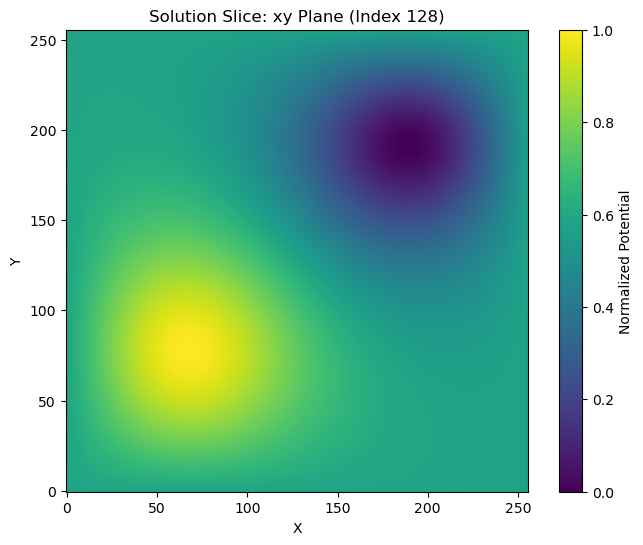

Residual norm: 8.068935579503215e-11


In [ ]:
%matplotlib inline
import pandas as pd

df = pd.DataFrame([], columns=['Solver Name', 'Grid Size', 'Start Date', 'End Date', 'Result', 'Residual'])

ni = nj = nk = 256
niter = 1000000
convergence_limit=1e-10

init_problem(np, ni, nj, nk)
p_solution, residual, start, end = solve_poisson_amgx(ni, nj, nk)
visualize_solution(p_solution)

print(f'Residual norm: {residual}')

df.loc[len(df)] = ['pyAMGX solver', ni, start, end, p_solution, residual]

df.to_csv(f'data-pyamgx-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

## Power Usage

In [ ]:
import numpy as np
import pyamgx
from scipy.sparse import csr_matrix
import time
from datetime import datetime
import cupy as cp
from numba import cuda


def get_curr_date():
    now = datetime.now()
    return now.strftime('%Y-%m-%d-%H-%M-%S') + f'-{now.microsecond // 1000:03d}'

@cuda.jit
def compute_matrix(ap3d, aw3d, ae3d, as3d, an3d, al3d, ah3d,
                   data, indices, indptr, ni, nj, nk):
    # Compute the thread's global index
    i, j, k = cuda.grid(3)

    if i < ni and j < nj and k < nk:
        idx = i * nj * nk + j * nk + k
        row_start = idx * 7  # Max 7 neighbors per node (including self)

        # Write self
        data[row_start] = ap3d[i, j, k]
        indices[row_start] = idx
        count = 1

        # Write neighbors
        if i > 0:  # West
            data[row_start + count] = -aw3d[i, j, k]
            indices[row_start + count] = (i - 1) * nj * nk + j * nk + k
            count += 1
        if i < ni - 1:  # East
            data[row_start + count] = -ae3d[i, j, k]
            indices[row_start + count] = (i + 1) * nj * nk + j * nk + k
            count += 1
        if j > 0:  # South
            data[row_start + count] = -as3d[i, j, k]
            indices[row_start + count] = i * nj * nk + (j - 1) * nk + k
            count += 1
        if j < nj - 1:  # North
            data[row_start + count] = -an3d[i, j, k]
            indices[row_start + count] = i * nj * nk + (j + 1) * nk + k
            count += 1
        if k > 0:  # Lower
            data[row_start + count] = -al3d[i, j, k]
            indices[row_start + count] = i * nj * nk + j * nk + (k - 1)
            count += 1
        if k < nk - 1:  # Upper
            data[row_start + count] = -ah3d[i, j, k]
            indices[row_start + count] = i * nj * nk + j * nk + (k + 1)
            count += 1

        # Write the pointer to the next row
        indptr[idx + 1] = row_start + count

def solve_poisson_amgx(ni, nj, nk):
    try:
        # Determine the mode and data type based on PRECISION
        mode = "dDDI" if PRECISION == np.float64 else "fDDI"
        dtype = PRECISION

        # Construct the sparse matrix in CSR format
        size = ni * nj * nk
        num_rows = ni * nj * nk
        max_elements = num_rows * 7  # Max 7 elements per row
        b = su3d.ravel().astype(dtype)

        # Output arrays
        data = np.zeros(max_elements, dtype=np.float32)
        indices = np.zeros(max_elements, dtype=np.int32)
        indptr = np.zeros(num_rows + 1, dtype=np.int32)

        # Transfer data to device
        d_ap3d = cuda.to_device(ap3d)
        d_aw3d = cuda.to_device(aw3d)
        d_ae3d = cuda.to_device(ae3d)
        d_as3d = cuda.to_device(as3d)
        d_an3d = cuda.to_device(an3d)
        d_al3d = cuda.to_device(al3d)
        d_ah3d = cuda.to_device(ah3d)
        d_data = cuda.to_device(data)
        d_indices = cuda.to_device(indices)
        d_indptr = cuda.to_device(indptr)

        threads_per_block = (8, 8, 8)
        blocks_per_grid = (ni // 8 + 1, nj // 8 + 1, nk // 8 + 1)
        compute_matrix[blocks_per_grid, threads_per_block](d_ap3d, d_aw3d, d_ae3d, d_as3d, d_an3d, d_al3d, d_ah3d,
                                                           d_data, d_indices, d_indptr, ni, nj, nk)

        # Copy results back to host
        data = d_data.copy_to_host()
        indices = d_indices.copy_to_host()
        indptr = d_indptr.copy_to_host()

        A = csr_matrix((data, indices, indptr), shape=(size, size))

        # Ensure data types match the mode
        A.data = A.data.astype(dtype)
        A.indices = A.indices.astype(np.int32)
        A.indptr = A.indptr.astype(np.int32)

        start = get_curr_date()
        start_time = time.perf_counter()

        for _ in range(100):
            # Solve the system
            pyamgx.initialize()

            # Configuration and resource setup
            cfg = pyamgx.Config().create_from_dict({
                "config_version": 2,
                "solver": {
                    "print_grid_stats": 0,
                    "store_res_history": 1,
                    "solver": "FGMRES",
                    "print_solve_stats": 0,
                    "obtain_timings": 0,
                    "preconditioner": {
                        "interpolator": "D2",
                        "solver": "AMG",
                        "smoother": {
                            "scope": "jacobi",
                            "solver": "JACOBI_L1"
                        },
                        "presweeps": 1,
                        "max_iters": 2,
                        "max_levels": 24,
                        "cycle": "V",
                        "postsweeps": 1
                    },
                    "max_iters": niter,
                    "monitor_residual": 1,
                    "gmres_n_restart": 10,
                    "convergence": "ABSOLUTE",
                    "tolerance": convergence_limit,
                    "norm": "L2"
                }
            })

            rsc = pyamgx.Resources().create_simple(cfg)

            # Create PyAMGX objects
            A_x = pyamgx.Matrix().create(rsc, mode=mode)
            b_x = pyamgx.Vector().create(rsc)
            x_x = pyamgx.Vector().create(rsc)

            # Upload the CSR matrix and vectors
            A_x.upload_CSR(A)
            b_x.upload(b)
            x_x.upload(np.zeros_like(b, dtype=dtype))

            # Create and configure solver
            solver = pyamgx.Solver().create(rsc, cfg)
            solver.setup(A_x)

            solver.solve(b_x, x_x)

            # Cleanup
            solver.destroy()
            A_x.destroy()
            b_x.destroy()
            x_x.destroy()
            rsc.destroy()
            pyamgx.finalize()

        end = get_curr_date()
        end_time = time.perf_counter()

        elapsed_time = end_time - start_time
        print(f"Elapsed time: {elapsed_time:.4f} seconds")

        return start, end

    except pyamgx.AMGXError as e:
        print(f"AMGX Error: {e}")
    finally:
        pyamgx.finalize()

In [ ]:
%matplotlib inline
import pandas as pd
import sys

df = pd.DataFrame([], columns=['Solver Name', 'Grid Size', 'Start Date', 'End Date', 'Result', 'Residual'])

ni = nj = nk = 128
niter = 1000000
convergence_limit=1e-10

init_problem(np, ni, nj, nk)

start, end = solve_poisson_amgx(ni, nj, nk)

(GB)       residual           rate
         ----------------------------------------------------------------------
            Ini             3.87396   7.071068e+01
              0             3.87396   8.335127e+00         0.1179
              1              3.8740   9.031740e-01         0.1084
              2              3.8740   1.056545e-01         0.1170
              3              3.8740   1.261108e-02         0.1194
              4              3.8740   1.389943e-03         0.1102
              5              3.8740   1.488418e-04         0.1071
              6              3.8740   1.836083e-05         0.1234
              7              3.8740   2.292571e-06         0.1249
              8              3.8740   3.140934e-07         0.1370
              9              3.8740   5.329467e-08         0.1697
             10              3.8740   1.287741e-08         0.2416
             11              3.8740   1.998359e-09         0.1552
             12              3.8740   3.27

In [ ]:
df.loc[len(df)] = ['pyAMGX solver', ni, start, end, p_solution, residual]

df.to_csv(f'power-pyamgx-{get_curr_date()}.csv', sep='\t', encoding='utf-8', header=True)

In [ ]:
import platform
platform.processor()

'x86_64'

In [ ]:
!lscpu

Architecture:            x86_64
  CPU op-mode(s):        32-bit, 64-bit
  Address sizes:         46 bits physical, 57 bits virtual
  Byte Order:            Little Endian
CPU(s):                  64
  On-line CPU(s) list:   0-63
Vendor ID:               GenuineIntel
  Model name:            Intel(R) Xeon(R) Gold 6338 CPU @ 2.00GHz
    CPU family:          6
    Model:               106
    Thread(s) per core:  1
    Core(s) per socket:  32
    Socket(s):           2
    Stepping:            6
    CPU(s) scaling MHz:  81%
    CPU max MHz:         3200.0000
    CPU min MHz:         800.0000
    BogoMIPS:            4000.00
    Flags:               fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mc
                         a cmov pat pse36 clflush dts acpi mmx fxsr sse sse2 ss 
                         ht tm pbe syscall nx pdpe1gb rdtscp lm constant_tsc art
                          arch_perfmon pebs bts rep_good nopl xtopology nonstop_
                         tsc cpuid aperfmperf pn

In [ ]:
convergence_limit = 1e-5
niter=1000
ni = nj = nk = 256

init_problem(np, ni, nj, nk)
start = get_curr_date()
p3d, resid = solve_cpu()
end = get_curr_date()

import pandas as pd

df = pd.DataFrame([], columns=['Solver Name', 'Start Date', 'End Date'])

df.loc[len(df)] = ['CPU Solver', start, end]
df.to_csv(f'cpu_power.csv', sep='\t', encoding='utf-8', header=True)